# Data Preparation

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import random
import uproot

In [5]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [6]:
# Read the ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
bb_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=1000) 

# Clean column names and remove unwanted columns
bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb_df.columns]
rename_columns(bb_df)
columns_to_remove = [col for col in bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb_df.drop(columns=columns_to_remove, inplace=True)
for col in bb_df.columns:
    if "SVtag" in col:
        bb_df[col] = bb_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_cc_pt20_50_dw.root" + ":" + path_to_tree)
cc_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=1000)

# Clean column names and remove unwanted columns
cc_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in cc_df.columns]
rename_columns(cc_df)
columns_to_remove = [col for col in cc_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
cc_df.drop(columns=columns_to_remove, inplace=True)
for col in cc_df.columns:
    if "SVtag" in col:
        cc_df[col] = cc_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_qq_pt20_50_dw.root" + ":" + path_to_tree)
qq_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=1000) 

# Clean column names and remove unwanted columns
qq_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in qq_df.columns]
rename_columns(qq_df)
columns_to_remove = [col for col in qq_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
qq_df.drop(columns=columns_to_remove, inplace=True)
for col in qq_df.columns:
    if "SVtag" in col:
        qq_df[col] = qq_df[col].apply(extract_float)
tree.close()

/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [7]:
print(f'There are {len(bb_df)} b-jet events (signal)')
print(f'There are {len(cc_df)} c-jet events (signal)')
print(f'There are {len(qq_df)} q-jet events (background)')

There are 1824752 b-jet events (signal)
There are 1694797 c-jet events (signal)
There are 2007289 q-jet events (background)


In [ ]:
# Apply cuts and truth matching
bb_df = bb_df[(bb_df['Jet0_MC_Match'] == 1) &
                (bb_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (bb_df['Jet0_PT'] > 20000) &
                (bb_df['Jet0_Eta'].between(2.2, 4.4))]
cc_df = cc_df[(cc_df['Jet0_MC_Match'] == 1) &
                (cc_df['Jet0_MC_Jet_EfD'] > 0.6) &
                (cc_df['Jet0_PT'] > 20000) &
                (cc_df['Jet0_Eta'].between(2.2, 4.4))]
qq_df = qq_df[(qq_df['Jet0_MC_Match'] == 1) &
                (qq_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (qq_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (qq_df['Jet0_PT'] > 20000) &
                (qq_df['Jet0_Eta'].between(2.2, 4.4))]

bc_df = pd.concat([bb_df, cc_df]).reset_index(drop=True)

# Read from csv and assign truth labels
sig_df = bc_df.assign(IsBC=1)
bkg_df = qq_df.assign(IsBC=0)

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsBC")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsBC")]]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

In [ ]:
print(f"Efficiency of signal truth matching is: {len(sig_df)/len(bc_df):.4f}")
print(f"Efficiency of background truth matching is: {len(bkg_df)/len(qq_df):.4f}")
print('')
print(f"Total events after truth matching: {len(combined_df)}")
print(f"Number of b/c-jets after truth matching: {len(sig_df)}")

Efficiency of signal truth matching is: 1.0000
Efficiency of background truth matching is: 1.0000

Total events after truth matching: 1681429
Number of b/c-jets after truth matching: 998420


In [ ]:
# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)

In [ ]:
# Split data into training, validation, and test sets
sig_df = df[df['IsBC'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = df[df['IsBC'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

half_train_size = int((sum(combined_df.IsBC)*0.8)/2)
half_test_size = int((sum(combined_df.IsBC)*0.2)/2)

train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of training data is: {len(train_df)}')

test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of testing data is: {len(test_df)}')

validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of validation data is: {len(validation_df)}')

Length of training data is: 798736
Length of testing data is: 199684
Length of validation data is: 683009


In [ ]:
print('Ratio of bc to q in datasets:')
print(f'    Training data: {sum(train_df.IsBC)/len(train_df)}')
print(f'    Testing data: {sum(test_df.IsBC)/len(test_df)}')
print(f'    Validation data: {sum(validation_df.IsBC)/len(validation_df)}')

Ratio of bc to q in datasets:
    Training data: 0.5
    Testing data: 0.5
    Validation data: 0.7308981287215834


The node features are processed into an array, so the data can be transformed into data object, representing one row or jet in the data. The feature array is used to create a tensor of the node features. The graphs are created with fully connected edges, but without self-connectioned nodes. The adjacency matrix of the graph is of size [number of nodes] x [number of nodes] filled with ones except the diagonal has zeros. The y tensor holds the truth labels, for graph-level classification. The data is then loaded in batches.

In [ ]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsBC'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Classifier

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch):        
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)
    
model = GNN()
model = model.to(device)

In [ ]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 200

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Save the model and results every 50 epochs
    if (epoch + 1) % 50 == 0:
        # Overwrite the existing model file
        torch.save(model.state_dict(), 'full_bcq_model1.pth')
        print('Model saved as full_bcq_model1.pth.')

        # Save the loss and accuracy values to a CSV file, overwriting the existing file
        results_df = pd.DataFrame({
            'Epoch': list(range(1, epoch + 2)),
            'Train Loss': train_loss_values,
            'Test Loss': test_loss_values,
            'Train Accuracy': train_acc_values,
            'Test Accuracy': test_acc_values
        })
        results_df.to_csv('full_bcq_training1.csv', index=False)
        print('Training results saved as full_bcq_training1.csv.')

torch.save(model.state_dict(), 'full_bcq_model1.pth')
print('Model saved as full_bcq_model1.pth. Training complete.')

results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values,
    'Test Loss': test_loss_values,
    'Train Accuracy': train_acc_values,
    'Test Accuracy': test_acc_values
})

# Save the loss and accuracy values to a CSV file
results_df.to_csv('full_bcq_training1.csv', index=False)
print('Training results saved as full_bcq_training1.csv. Training complete.')

Epoch: 001, Train Loss: 0.5151, Test Loss: 0.4941, Train Acc: 0.7352, Test Acc: 0.7336
Epoch: 002, Train Loss: 0.4959, Test Loss: 0.4933, Train Acc: 0.7345, Test Acc: 0.7326
Epoch: 003, Train Loss: 0.4923, Test Loss: 0.4897, Train Acc: 0.7373, Test Acc: 0.7355
Epoch: 004, Train Loss: 0.4903, Test Loss: 0.4885, Train Acc: 0.7377, Test Acc: 0.7360
Epoch: 005, Train Loss: 0.4890, Test Loss: 0.4872, Train Acc: 0.7371, Test Acc: 0.7348
Epoch: 006, Train Loss: 0.4882, Test Loss: 0.4913, Train Acc: 0.7343, Test Acc: 0.7327
Epoch: 007, Train Loss: 0.4873, Test Loss: 0.4863, Train Acc: 0.7388, Test Acc: 0.7370
Epoch: 008, Train Loss: 0.4865, Test Loss: 0.4867, Train Acc: 0.7377, Test Acc: 0.7353
Epoch: 009, Train Loss: 0.4860, Test Loss: 0.4854, Train Acc: 0.7381, Test Acc: 0.7363
Epoch: 010, Train Loss: 0.4853, Test Loss: 0.4833, Train Acc: 0.7405, Test Acc: 0.7390
Epoch: 011, Train Loss: 0.4847, Test Loss: 0.4880, Train Acc: 0.7367, Test Acc: 0.7356
Epoch: 012, Train Loss: 0.4838, Test Loss: 

KeyboardInterrupt: 

In [ ]:
# Reload training data to produce plots
training = pd.read_csv('full_bcq_training1.csv')
train_loss_values = training['Train Loss'].to_list()
test_loss_values = training['Test Loss'].to_list()
train_acc_values = training['Train Accuracy'].to_list()
test_acc_values = training['Test Accuracy'].to_list()

NameError: name 'pd' is not defined

In [ ]:
training

,Epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy
0,1,0.929757,0.777007,0.585202,0.581818
1,2,0.817636,0.744690,0.625561,0.618182
2,3,0.809775,0.709862,0.652466,0.600000
3,4,0.740529,0.686273,0.659193,0.618182
4,5,0.787200,0.694458,0.659193,0.627273
...,...,...,...,...,...
195,196,0.570600,0.596844,0.726457,0.627273
196,197,0.604322,0.596844,0.726457,0.627273
197,198,0.609003,0.596847,0.726457,0.627273
198,199,0.606272,0.596850,0.726457,0.627273


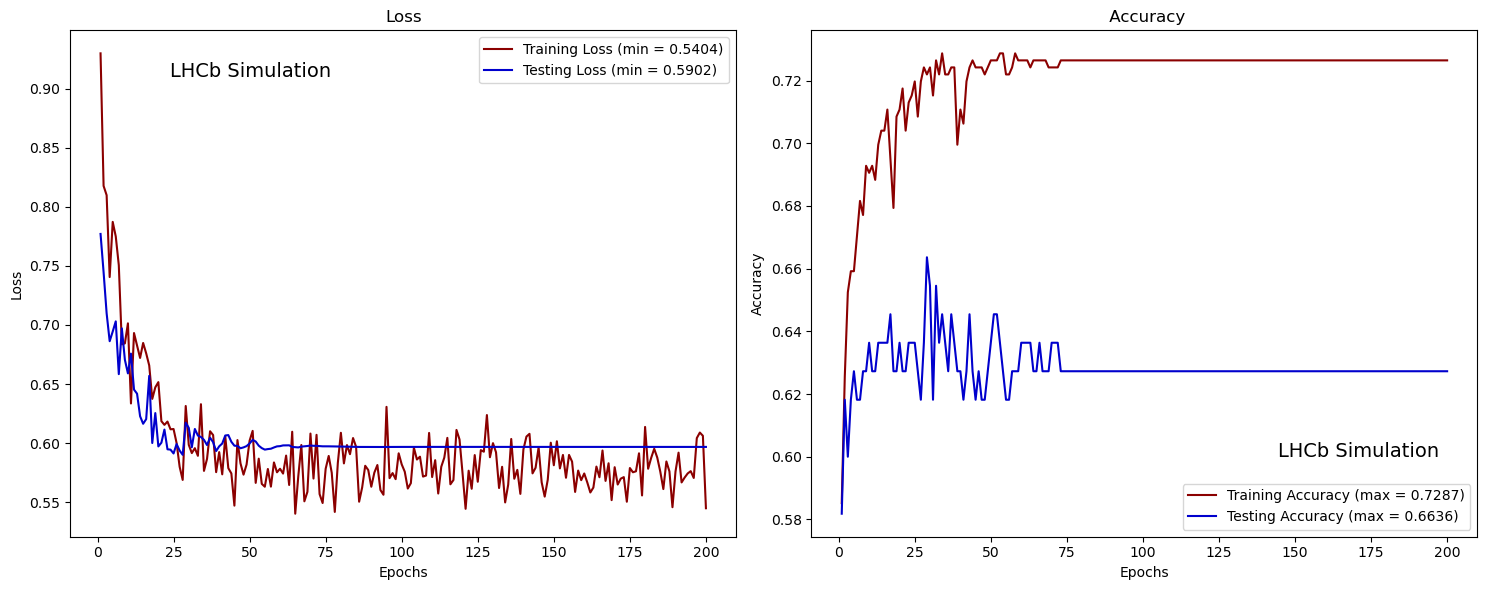

In [ ]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = np.mean(train_loss_values)
    mean_test_loss = np.mean(test_loss_values)
    mean_train_acc = np.mean(train_acc_values)
    mean_test_acc = np.mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))

    ax1.text(0.15, 0.90, "LHCb Simulation", transform=ax1.transAxes, fontsize=14, verticalalignment='bottom')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))

    ax2.text(0.7, 0.15, "LHCb Simulation", transform=ax2.transAxes, fontsize=14, verticalalignment='bottom')

    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
# After your training loop, call the function:
plot_training_results()

In [ ]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.load_state_dict(torch.load('full_bcq_model1.pth'))
model = model.to('cpu')
model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

np.save('full_bcq_roc_data1.npy', np.array([fpr, tpr, thresholds, auc]))

/tmp/ipykernel_165842/239473012.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('full_bcq_roc_data1.npy', np.array([fpr, tpr, thresholds, auc]))


In [ ]:
# Get FPRs for TPRs
desired_tpr = [0.85, 0.80, 0.75, 0.70, 0.65, 0.60]

print("Efficiency | FPR ")
for val in desired_tpr:
    # Find the index of the closest TPR to the desired TPR value
    closest_index = np.argmin(np.abs(tpr - val))

    # Get the chosen threshold and corresponding FPR, where the threshold is the probability cutoff
    chosen_threshold = thresholds[closest_index]
    given_fpr = fpr[closest_index]
    print(f"{val}: {given_fpr:.4f}")

Efficiency | FPR 
0.85: 0.3601
0.8: 0.2785
0.75: 0.2085
0.7: 0.1515
0.65: 0.1037
0.6: 0.0610


In [ ]:
chosen_tpr = 0.75
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pbc {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.75: Pbc 0.4537: FPR 0.2085


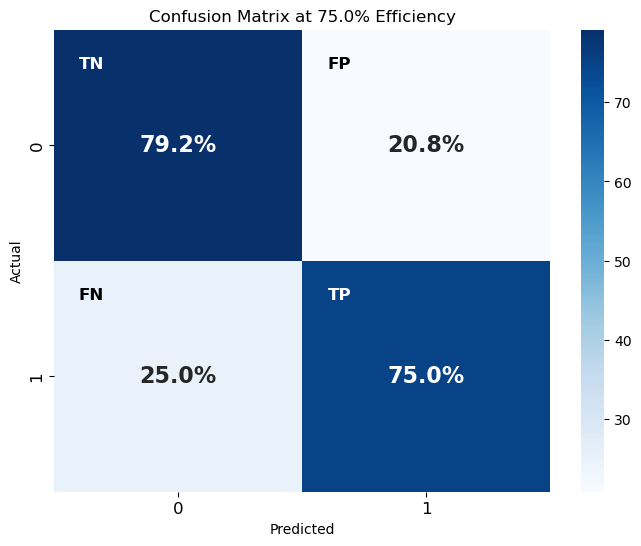

In [ ]:
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

cm_percentage = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

annot_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm_percentage[i, j]
        annot_labels[i, j] = f'{percentage:.1f}%'

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

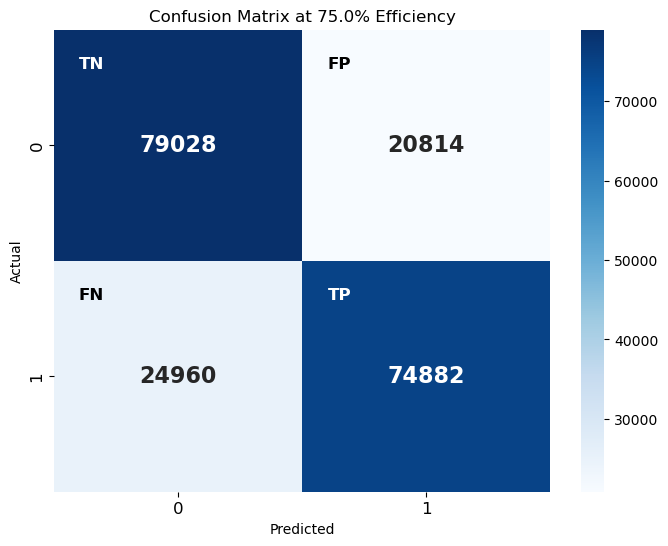

In [ ]:
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

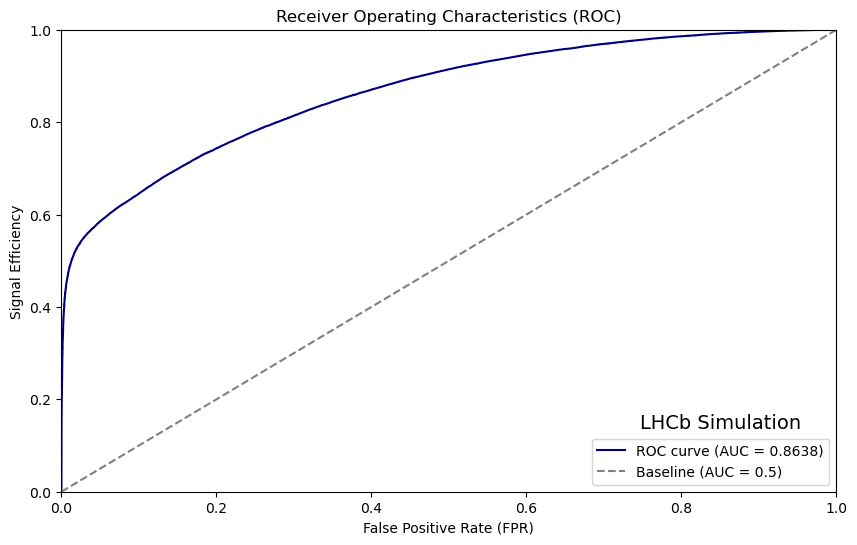

In [ ]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.text(0.85, 0.15, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.legend(loc='lower right')
plt.show()

                                Feature  Importance
0                      Jet0_Daughters_E    0.624408
1                     Jet0_Daughters_pT    0.624507
2                     Jet0_Daughters_ID    0.040190
3                     Jet0_Daughters_pX    0.137703
4                     Jet0_Daughters_pY    0.028825
5                     Jet0_Daughters_pZ    1.275191
6                    Jet0_Daughters_Eta    0.004937
7                    Jet0_Daughters_Phi    0.001312
8                      Jet0_Daughters_Q    0.000204
9                     Jet0_Daughters_IP    0.013319
10                Jet0_Daughters_IPCHI2    1.175925
11                 Jet0_Daughters_IPraw    0.009633
12                   Jet0_Daughters_NNe    0.054954
13                   Jet0_Daughters_NNk    0.062701
14                   Jet0_Daughters_NNp    0.076542
15                  Jet0_Daughters_NNpi    0.094848
16                  Jet0_Daughters_NNmu    2.719597
17                  Jet0_Daughters_Chi2    0.068269
18          

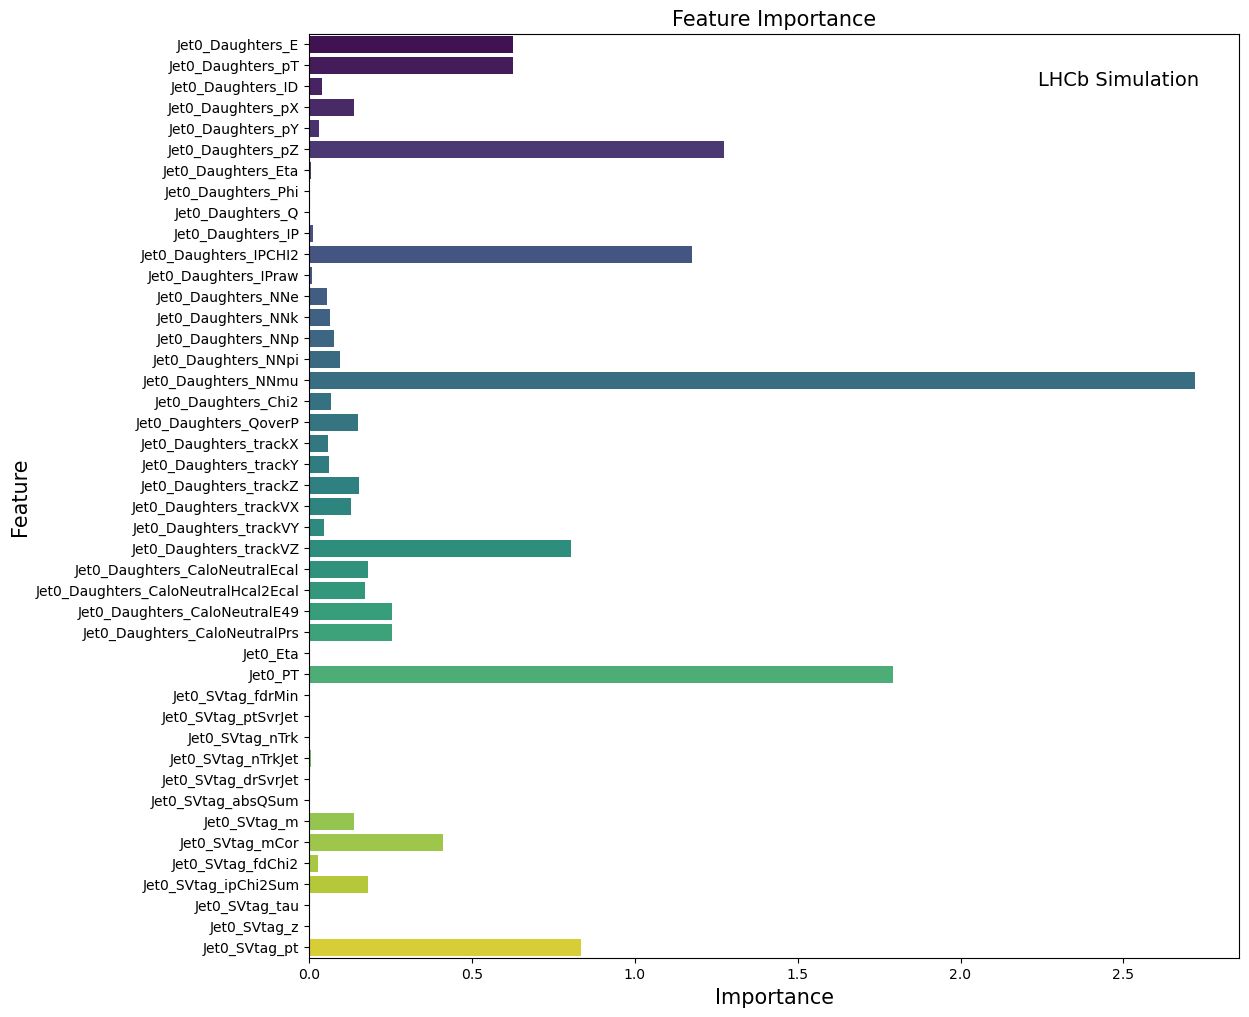

In [ ]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance', fontsize=15)
plt.text(0.87, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.show()

In [ ]:
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_Daughters_E & 0.624408
Jet0_Daughters_pT & 0.624507
Jet0_Daughters_pZ & 1.275191
Jet0_Daughters_IPCHI2 & 1.175925
Jet0_Daughters_NNmu & 2.719597
Jet0_Daughters_trackVZ & 0.803404
Jet0_Daughters_CaloNeutralE49 & 0.253040
Jet0_Daughters_CaloNeutralPrs & 0.254895
Jet0_PT & 1.792352
Jet0_SVtag_mCor & 0.412224
Jet0_SVtag_pt & 0.835417


# Model Probability Output

In [ ]:
df = validation_df

def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin',
    'Jet0_SVtag_ptSvrJet',
    'Jet0_SVtag_nTrk',
    'Jet0_SVtag_nTrkJet',
    'Jet0_SVtag_drSvrJet',
    'Jet0_SVtag_absQSum',
    'Jet0_SVtag_m',
    'Jet0_SVtag_mCor',
    'Jet0_SVtag_fdChi2',
    'Jet0_SVtag_ipChi2Sum',
    'Jet0_SVtag_tau',
    'Jet0_SVtag_z',
    'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    for col in jet_cols:
        sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    for col in daughter_cols:
        sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int()

    print(f'Probability: {probability.item()}')
    if prediction.item() == 1:  
        print(f'Prediction: b/c-jet')
    if prediction.item() == 0:  
        print(f'Prediction: q-jet')
    return probability.item()

i = 0

for i in range(100):
    bprob = make_predictions()
    qprob = make_predictions()

Probability: 0.997837483882904
Prediction: b/c-jet
Probability: 0.9974731802940369
Prediction: b/c-jet
Probability: 0.39326101541519165
Prediction: q-jet
Probability: 0.26599371433258057
Prediction: q-jet
Probability: 0.2258376181125641
Prediction: q-jet
Probability: 0.9988641738891602
Prediction: b/c-jet
Probability: 0.44954049587249756
Prediction: q-jet
Probability: 0.0929868221282959
Prediction: q-jet
Probability: 0.9766958355903625
Prediction: b/c-jet
Probability: 0.9928926229476929
Prediction: b/c-jet
Probability: 0.45256564021110535
Prediction: q-jet
Probability: 0.9933658242225647
Prediction: b/c-jet
Probability: 0.4137907922267914
Prediction: q-jet
Probability: 0.24596469104290009
Prediction: q-jet
Probability: 0.5129367113113403
Prediction: b/c-jet
Probability: 0.5377631783485413
Prediction: b/c-jet
Probability: 0.3801742196083069
Prediction: q-jet
Probability: 0.18372461199760437
Prediction: q-jet
Probability: 0.22402942180633545
Prediction: q-jet
Probability: 0.1311716586351

# Create Efficiency Plot

In [ ]:
model.load_state_dict(torch.load('full_bcq_model1.pth'))
model = model.to('cpu')

NameError: name 'model' is not defined

In [ ]:
# Separate b and q data from testing dataset (preprocessed)
bc = test_df[test_df.IsBC == 1]
q = test_df[test_df.IsBC == 0]

bc_data = create_graphs(bc, feature_cols)
q_data = create_graphs(q, feature_cols)

bc_prob = []
q_prob = []

def get_probabilities(data_list):
    prob_list = []
    model.eval()
    with torch.no_grad():
        for data in data_list:
            out = model(data.x, data.edge_index, data.batch)
            prob = torch.sigmoid(out).numpy().flatten()
            prob_list.append(prob)
    return np.concatenate(prob_list)

# Compute probabilities for b and q data
bc_prob = get_probabilities(bc_data)
q_prob = get_probabilities(q_data)

NameError: name 'test_df' is not defined

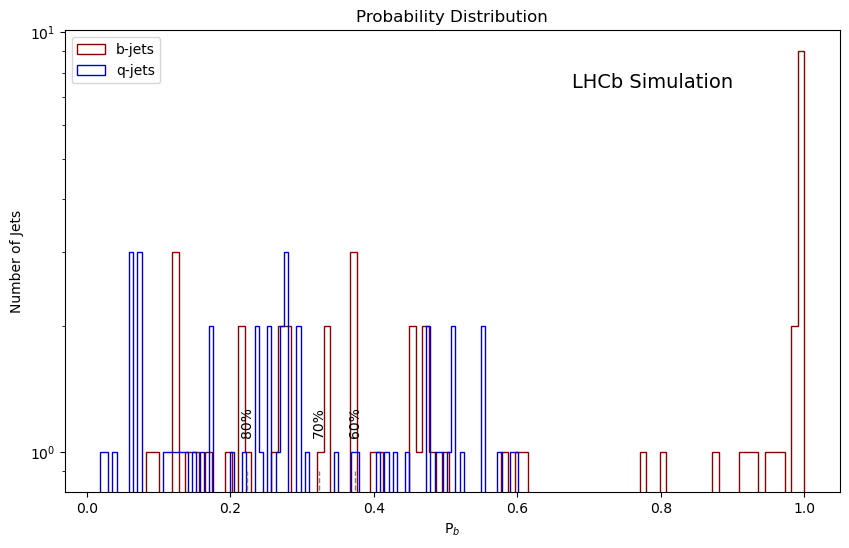

In [ ]:
def plot_probability_distribution(bc_prob, q_prob, target_efficiencies):

    # Sort b-jet probabilities in descending order for cutoff calculations
    sorted_b_prob = np.sort(bc_prob)[::-1]
    
    # Calculate cutoffs for each efficiency level
    cutoffs = {}
    for efficiency in target_efficiencies:
        cutoff_index = int(len(sorted_b_prob) * efficiency)
        cutoffs[efficiency] = sorted_b_prob[cutoff_index - 1] if cutoff_index > 0 else sorted_b_prob[0]
    
    # Plot histograms for b-jet and q-jet probabilities
    plt.figure(figsize=(10, 6))
    bc_values, bc_bins, _ = plt.hist(bc_prob, bins=100, label='b-jets', color='darkred', histtype='step')
    q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='q-jets', color='mediumblue', histtype='step')

    max_y = max(max(bc_values), max(q_values))
    
    # Mark cutoffs for selected efficiencies
    for i, (efficiency, cutoff) in enumerate(cutoffs.items()):
        plt.vlines(x=cutoff, ymin=0, ymax=max_y * 0.1, color='grey', linestyle='--', linewidth=1)
        plt.text(cutoff, max_y*0.12, f'{int(efficiency * 100)}%', ha='center', va='bottom', rotation=90)

    plt.xlabel("P$_b$")
    plt.ylabel("Number of Jets")
    plt.text(0.9, max_y * 0.8, "LHCb Simulation", fontsize=14, verticalalignment='bottom', horizontalalignment='right')
    plt.title("Probability Distribution")
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()

target_efficiencies = [0.6, 0.7, 0.8]
plot_probability_distribution(bc_prob, q_prob, target_efficiencies)

In [ ]:
chosen_tpr = 0.75
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pbc {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.75: Pbc 0.2715: FPR 0.4909


In [ ]:
bc = test_df[test_df.IsBC == 1]
bc.loc[:, 'Jet0_PT'] = bc['Jet0_PT'].apply(lambda x: x[0] if isinstance(x, list) else x)

pt23_df = bc[(bc['Jet0_PT'].between(20000, 30000))].reset_index(drop=True)
pt34_df = bc[(bc['Jet0_PT'].between(30000, 40000))].reset_index(drop=True)
pt45_df = bc[(bc['Jet0_PT'].between(40000, 50000))].reset_index(drop=True)

In [ ]:
def make_predictions(df):
    daughter_cols = [col for col in df.columns if "_Daughters" in col]
    svtag_cols = [
        'Jet0_SVtag_fdrMin',
        'Jet0_SVtag_ptSvrJet',
        'Jet0_SVtag_nTrk',
        'Jet0_SVtag_nTrkJet',
        'Jet0_SVtag_drSvrJet',
        'Jet0_SVtag_absQSum',
        'Jet0_SVtag_m',
        'Jet0_SVtag_mCor',
        'Jet0_SVtag_fdChi2',
        'Jet0_SVtag_ipChi2Sum',
        'Jet0_SVtag_tau',
        'Jet0_SVtag_z',
        'Jet0_SVtag_pt'
    ]
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Get features of each node within the graph
    features_list = []
    for _, row in df.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    num_bc = 0
    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int()

            if prediction.item() == 1:  
                num_bc += 1

    return num_bc

In [ ]:
num_bc23 = make_predictions(pt23_df)
num_bc34 = make_predictions(pt34_df)
num_bc45 = make_predictions(pt45_df)

In [ ]:
efficiency23 = num_bc23 / len(pt23_df)
efficiency34 = num_bc34 / len(pt34_df)
efficiency45 = num_bc45 / len(pt45_df)

print(f'Efficiency for pT 20-30 GeV: {efficiency23:.4f}')
print(f'Efficiency for pT 30-40 GeV: {efficiency34:.4f}')
print(f'Efficiency for pT 40-50 GeV: {efficiency45:.4f}')

Efficiency for pT 20-30 GeV: 0.7500
Efficiency for pT 30-40 GeV: 0.9167
Efficiency for pT 40-50 GeV: 0.3333


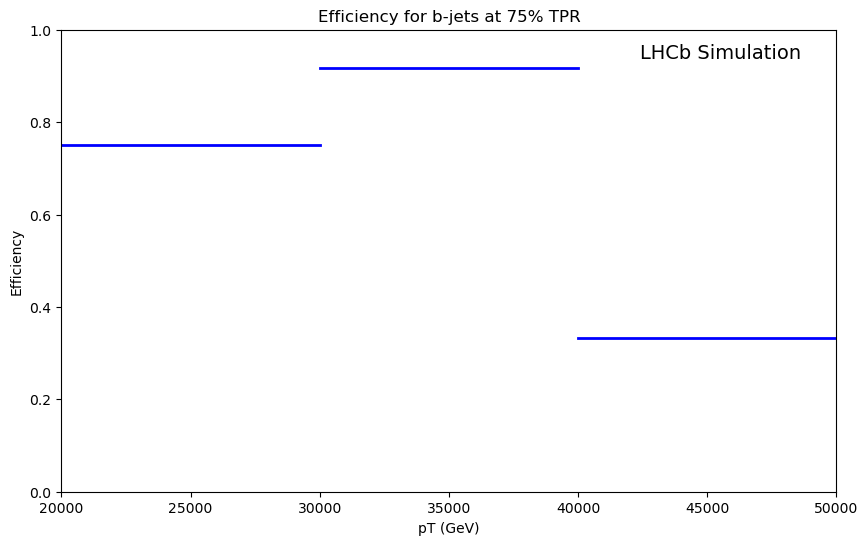

In [ ]:
def plot_efficiency_histogram(efficiencies, pt_bins):
    plt.figure(figsize=(10, 6))

    # Calculate bin centers and widths
    bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
    bar_width = np.diff(pt_bins)  # Width of the bins

    # Create the histogram by plotting only the tops of the bins
    for i in range(len(efficiencies)):
        plt.plot([pt_bins[i], pt_bins[i+1]], [efficiencies[i], efficiencies[i]], color='blue', linewidth=2)
    plt.xticks(np.arange(20000, 51000, 5000))
    plt.xlabel('pT (GeV)')
    plt.ylabel('Efficiency')
    plt.text(0.85, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
    plt.title('Efficiency for b/c-jets at 75% TPR')
    plt.ylim(0, 1)
    plt.xlim(20000,50000)
    plt.show()

pt_bins = np.array([20000, 30000, 40000, 50000])
efficiencies = [efficiency23, efficiency34, efficiency45]

plot_efficiency_histogram(efficiencies, pt_bins)